# Calculations and figures for manuscript

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle

import os
import sys
sys.path.append('../Parameters')
sys.path.append('../Parameters/Bcd_data/')
sys.path.append('../AnalyticalModel')
sys.path.append('../StochasticModel/')
sys.path.append('../Analysis')

In [2]:
import seaborn as sns

sns.set_theme(context='talk', style='ticks', palette='deep', font='sans-serif', font_scale=1, 
              color_codes=True, rc=None)

In [8]:
import seaborn as sns

sns.set_theme(context='talk', style='ticks', palette='deep', font='sans-serif', font_scale=1, 
              color_codes=True, rc={'patch.edgecolor': 'none'}) # For histograms

# Single timetrace

In [3]:
from Metadata import read_metadata
from Parameters import RunParameters

file_name = 'TimeSweep/TimeSweep_6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-05-19_60'
file      = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}') 

grid_prms, sim_prms, varied_prms = read_metadata(file)
htf, eb, J = varied_prms.htf_list[4], varied_prms.eb_list[2], varied_prms.J_list[2]
print(f'htf = {htf}, eb = {eb}, J = {J}')
run_prms = RunParameters(htf, eb, J, varied_prms.IC_prms_list[f'J{J}eb{eb}htf{htf}'], grid_prms)

htf = -14.0, eb = 8.23962329975328, J = 7.0


In [5]:
from Grid1D import TF_Grid_1D
from Grid2D import TF_Grid_2D
from Data import DataFile
from Gillespie import GillespieSim

from Data import sample_output

def single_timetrace():
    ## Generate grid
    if grid_prms.dim == 1:
        simulation_grid = TF_Grid_1D(run_prms, grid_prms)
    elif grid_prms.dim == 2:
        simulation_grid = TF_Grid_2D(run_prms, grid_prms)
    else:
        raise ValueError('Unsuported grid dimension: {grid_prms.dim}.')

    ## Generate datafile
    datafile = DataFile(simulation_grid)

    ## Generate simulation
    simulation = GillespieSim(simulation_grid, datafile)

    ## Run simulation
    simulation.run(sim_prms.T)
    t_unsampled, N_bound_unsampled = datafile.get_N_bound()
    t_sampled, N_bound_sampled = sample_output(t_unsampled, N_bound_unsampled, sim_prms.T, 500)
    
    return t_sampled, N_bound_sampled

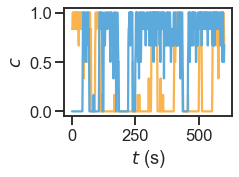

In [7]:
t_sampled1, N_bound_sampled1 = single_timetrace()
t_sampled2, N_bound_sampled2 = single_timetrace()

plt.figure(figsize=(3,2))
plt.plot(t_sampled1*grid_prms.time_conversion, N_bound_sampled1/6, color='#FBB44D')
plt.plot(t_sampled2*grid_prms.time_conversion, N_bound_sampled2/6, color='#5CAADB')
# plt.xticks([0,600])
# plt.yticks([0,1])
plt.xlabel('$t$ (s)')
plt.ylabel('$c$')

plt.savefig(f'../Figures/TimeTraceExample.svg', bbox_inches="tight")

# Probability distribution

In [5]:
from Metadata import read_metadata
from FileReader import read_data
from FullMatrix import FullStates

def load_timeSweepData(datafile_idxs):
    T_list            = []
    data_list         = []
    steady_state_list = []
    means_list        = []
    stds_list         = []
    means_limit_list  = []
    stds_limit_list   = []

    for i in range(161):
        file_name = 'TimeSweep/TimeSweep_6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-05-19_'+f'{i}'
        file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}')

        grid_prms, sim_prms, varied_prms = read_metadata(file)

        T_list.append(sim_prms.T*grid_prms.time_conversion)

        if i in datafile_idxs:
            data = []
            for j, (J, eb) in enumerate(zip(varied_prms.J_list, varied_prms.eb_list)):
                data.append([])
                for h, htf in enumerate(varied_prms.htf_list):
                    dataset = read_data(file+f'_J{J}eb{eb}htf{htf}', sim_prms.runs)
                    data[-1].append(np.array(dataset[0]['mean binding site occupancy'], dtype='float'))
            data_list.append(data)

        f = open(file+'_steady_states', 'rb')
        steady_states = pickle.load(f)
        f.close()

        probabilities = []
        S = FullStates(grid_prms.L)
        sites = grid_prms.sites.flatten()
        for J, eb in zip(varied_prms.J_list, varied_prms.eb_list):
            probabilities.append([])
            for htf in varied_prms.htf_list:
                probabilities[-1].append(S.compact_states(steady_states[f'J{J}eb{eb}htf{htf}'][1], sites))
        steady_state_list.append(np.array(probabilities))

        f = open(file+'_means_and_vars', 'rb')
        means_and_vars = pickle.load(f)
        f.close()

        means = []
        stds  = []
        for J, eb in zip(varied_prms.J_list, varied_prms.eb_list):
            means.append([])
            stds.append([])
            for htf in varied_prms.htf_list:
                mu, sigma_squared = means_and_vars[f'J{J}eb{eb}htf{htf}']
                means[-1].append(mu)
                stds[-1].append(np.sqrt(sigma_squared))
        means = np.array(means)
        stds  = np.array(stds)

        means_list.append(means)
        stds_list.append(stds)

        f = open(file+'_means_and_vars_limit', 'rb')
        means_and_vars = pickle.load(f)
        f.close()

        means_limit = []
        stds_limit  = []
        for J, eb in zip(varied_prms.J_list, varied_prms.eb_list):
            means_limit.append([])
            stds_limit.append([])
            for htf in varied_prms.htf_list:
                mu, sigma_squared = means_and_vars[f'J{J}eb{eb}htf{htf}']
                means_limit[-1].append(mu)
                stds_limit[-1].append(np.sqrt(sigma_squared))
        means_limit = np.array(means_limit)
        stds_limit  = np.array(stds_limit)

        means_limit_list.append(means_limit)
        stds_limit_list.append(stds_limit)

    idxs              = np.argsort(T_list)
    T_list            = np.array(T_list)[idxs]
    T_idxs            = np.where(np.any([idxs == i for i in datafile_idxs], axis=0))[0]
    data_idxs         = np.concatenate([np.where(datafile_idxs == i)[0] for i in idxs[T_idxs]])
    data_list         = np.array(data_list)[data_idxs]
    steady_state_list = np.array(steady_state_list)[idxs]
    means_list        = np.array(means_list)[idxs]
    stds_list         = np.array(stds_list)[idxs]
    means_limit_list  = np.array(means_limit_list)[idxs]
    stds_limit_list   = np.array(stds_limit_list)[idxs]
    
    print(datafile_idxs)
    print(idxs)
    print(T_idxs)
    print(idxs[T_idxs])
    print(data_idxs)

    return grid_prms, sim_prms, varied_prms, T_list, T_idxs, data_idxs, data_list, steady_state_list, means_list, stds_list, means_limit_list, stds_limit_list

In [6]:
# Time sweep files 0-100 contain results for log spaced averaging times between 0.01 and 1000 min.
# Time sweep files 101-160 contain results for log spaced averaging times between 0.00001 and 0.01 min.
# Note that from 70 to 100, results are only available for every 10th index (70, 80, 90, 100), since calculations took too long.

datafile_idxs = np.array([0,10,20,30,40,50,60,70,80,90,100,101,111,121,131,141,151]) # For distribution plots

grid_prms, sim_prms, varied_prms, T_list, T_idxs, data_idxs, data_list, steady_state_list, means_list, stds_list, means_limit_list, stds_limit_list = load_timeSweepData(datafile_idxs)

[  0  10  20  30  40  50  60  70  80  90 100 101 111 121 131 141 151]
[101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160   0   1   2   3   4   5   6   7   8   9  10  11
  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100]
[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160]
[101 111 121 131 141 151   0  10  20  30  40  50  60  70  80  90 100]
[11 12 13 14 15 16  0  1  2  3  4  5  6  7  8  9 10]


C:\Users\tamaramijatovi\AppData\Local\Temp\ipykernel_15736\1359028095.py:56: RuntimeWarning: invalid value encountered in sqrt
  stds[-1].append(np.sqrt(sigma_squared))


T = 600.0 seconds
htf = -15.0, J = 0.0
htf = -14.0, J = 0.0
htf = -13.0, J = 0.0
htf = -15.0, J = 7.0
htf = -14.0, J = 7.0
htf = -13.0, J = 7.0


C:\Users\tamaramijatovi\AppData\Local\Temp\ipykernel_15736\2163606176.py:17: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  hist_values, bin_edges, _ = ax.hist(data_list[12,j,h], N_bins, [0,1], density=True, color=color, rwidth=1, )
C:\Users\tamaramijatovi\AppData\Local\Temp\ipykernel_15736\2163606176.py:27: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  hist_values, bin_edges, _ = plt.hist(data_list[12,2,4], N_bins, [0,1], density=True, color='#5CAADB', rwidth=1)


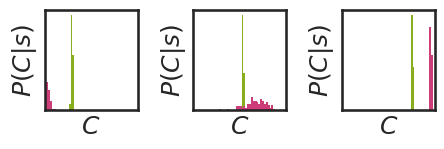

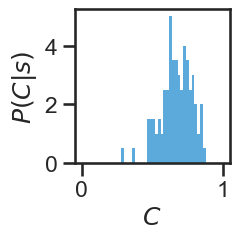

In [21]:
N_bins = 50

fig, axs = plt.subplots(1,3, figsize=(5,2))
fig.tight_layout(w_pad=0)

print(f'T = {T_list[T_idxs[12]]} seconds')

for j, color in zip([0,2], ['#88AE1D', '#CD3E78']):
    for i,h in enumerate([2,4,6]):
        htf = varied_prms.htf_list[h]
        J   = varied_prms.J_list[j]
        print('htf = '+f'{htf}, J = {J}')
        
        ax = axs.flatten()[i]
        
        # Plot histogram
        hist_values, bin_edges, _ = ax.hist(data_list[12,j,h], N_bins, [0,1], density=True, color=color, rwidth=1, )
        ax.set_ylabel('$P(C|s)$')
        ax.set_xlabel('$C$')
        ax.set_xlim([0,1])
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig(f'../Figures/HistogramOverview.svg', bbox_inches="tight")

plt.figure(figsize=(2,2))
hist_values, bin_edges, _ = plt.hist(data_list[12,2,4], N_bins, [0,1], density=True, color='#5CAADB', rwidth=1)
plt.ylabel('$P(C|s)$')
plt.xlabel('$C$')

plt.savefig(f'../Figures/Histogram_htf{round(varied_prms.htf_list[4])}J{round(varied_prms.J_list[2])}.svg', bbox_inches="tight")

# Binding curve properties after shift compensation

In [90]:
from Parameters import GridParameters
from Parameters import RunParameters
import ParametersFromLiterature as prms
from Metadata import read_metadata

def read_files_shift_compensation(file):
    shift_compensation = None
    try:
        f = open(file+'_shift_compensation', 'rb')
        shift_compensation = pickle.load(f)
        f.close()
    except:
        print('Shift compensation could not be loaded.')
    return shift_compensation

def read_files_means(file, varied_prms):
    means_dict         = None
    means              = None
    try:
        f = open(file+'_means', 'rb')
        means_dict = pickle.load(f)
        f.close()

        means = []
        for J, eb in zip(varied_prms.J_list, varied_prms.eb_list):
            means.append([])
            for htf in varied_prms.htf_list:
                means[-1].append(means_dict[f'J{J}eb{eb}htf{htf}'])
        means = np.array(means)
    except:
        print('Means could not be loaded.')
    return means_dict, means

def read_files_means_and_vars(file, varied_prms, instantaneous=False):
    means_and_vars     = None
    means              = None
    stds               = None
    try:
        if instantaneous:
            f = open(file+'_means_and_instantaneous_vars', 'rb')
        else:
            f = open(file+'_means_and_vars', 'rb')
        means_and_vars = pickle.load(f)
        f.close()

        means = []
        stds  = []
        for J, eb in zip(varied_prms.J_list, varied_prms.eb_list):
            means.append([])
            stds.append([])
            for htf in varied_prms.htf_list:
                mu, sigma_squared = means_and_vars[f'J{J}eb{eb}htf{htf}']
                means[-1].append(mu)
                stds[-1].append(np.sqrt(sigma_squared))
        means = np.array(means)
        stds  = np.array(stds)
    except:
        print('Means and vars could not be loaded.')
    return means_and_vars, means, stds

J = 0.0, e_b = 14.143319868324545: Effective hill coefficient = 1.0000017187947547
J = 7.0, e_b = 8.23962329975328: Effective hill coefficient = 3.8352091765847187
J = 0.0, e_b = 14.143319868324545: Effective hill coefficient = 1.0000017187947006
J = 7.0, e_b = 8.23962329975328: Effective hill coefficient = 3.83853326812623


C:\Users\tamaramijatovi\AppData\Local\Temp\ipykernel_15736\1358599802.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_opt[i], _ = sp.optimize.curve_fit(Hill_eqn, conc_range, mean, bounds = ([0,100]))


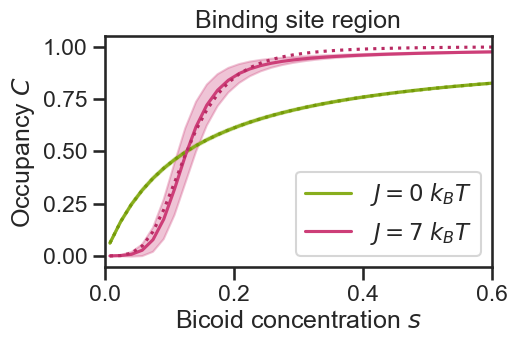

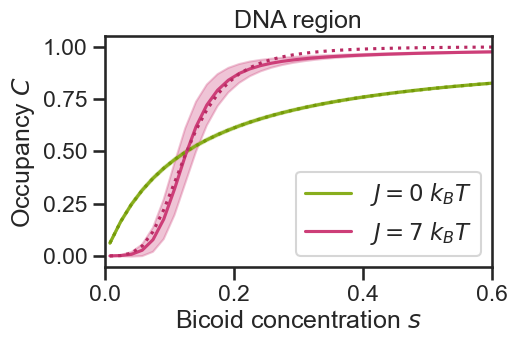

In [23]:
from GetExpression import get_expression_mean_and_var_steady_state
from bcd import read_bcd_data, discretize_concentrations

file_names = ['Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30',\
              'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30']

bcd_data = read_bcd_data('../../Parameters/Bcd_data/TG_normBcd')
number_of_samples = 60
rel_conc_bins, _, _ = discretize_concentrations(bcd_data, number_of_samples)

colors = ['#88AE1D', '#CD3E78']
dark_colors = ['#749a09', '#b92a63']

for file_name, ID, padding in zip(file_names, ['SSNN', 'SS2N'], ['Binding site region', 'DNA region']):
    file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}')

    grid_prms, _, varied_prms = read_metadata(file)
    shift_compensation        = read_files_shift_compensation(file)
    _, means, stds            = read_files_means_and_vars(file, varied_prms)
        
    conc_range = prms.htf_to_c(grid_prms.beta, varied_prms.htf_list)
    c_05       = prms.htf_to_c(grid_prms.beta, shift_compensation.htf_05)
    Hill_eqn   = lambda c, n : prms.Hill_eqn(c, c_05, n)
    
    #xs = conc_range/prms.V_site/(prms.N_Avogadro/(10**24))
    xs = rel_conc_bins[:-1]+1/(2*number_of_samples)
    
    plt.figure(figsize=(5,3))
    ax = plt.gca()
    
    ## Mean and standard deviation of expression (shift compensated)
    #idxs = np.arange(0,len(varied_prms.J_list),2)
    idxs = [0, 7]

    for J, eb, expression, stdev, color in zip(varied_prms.J_list[idxs], varied_prms.eb_list[idxs], means[idxs], stds[idxs], colors):
        ax.plot(xs, expression, color=color, label=f'$J={round(J)}$ $k_BT$') #label=f'$J={round(J)}\ k_BT$,\n$e_b\\approx{round(eb,1)}\ k_BT$')
        ax.fill_between(xs, expression-stdev, expression+stdev, color=color, alpha=0.3)#, label='Standard deviation ($T_{avg}=10$ min.)')

    ## Hill equation fits
    n_opt = np.zeros(len(idxs))
    for i, mean in enumerate(means[idxs]):
        n_opt[i], _ = sp.optimize.curve_fit(Hill_eqn, conc_range, mean, bounds = ([0,100]))
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
        
        ax.plot(xs, prms.Hill_eqn(conc_range, c_05, n_opt[i]), ':', color=dark_colors[i])#, label='Hill equation fit')

    for j, (J, eb) in enumerate(zip(varied_prms.J_list[idxs], varied_prms.eb_list[idxs])):
        print(f'J = {J}, e_b = {eb}: Effective hill coefficient = {n_opt[j]}')
        
    ## Plotting
    ax.set_xlabel('Bicoid concentration $s$')
    ax.set_ylabel('Occupancy $C$')
    ax.set_title(padding)
    ax.legend(loc='lower right')
    ax.set_xlim([0,0.6])
    
    plt.savefig(f'../Figures/Manuscript_ExpressionCrurvesWithHillEquationFits_600s_{ID}.svg',bbox_inches="tight")

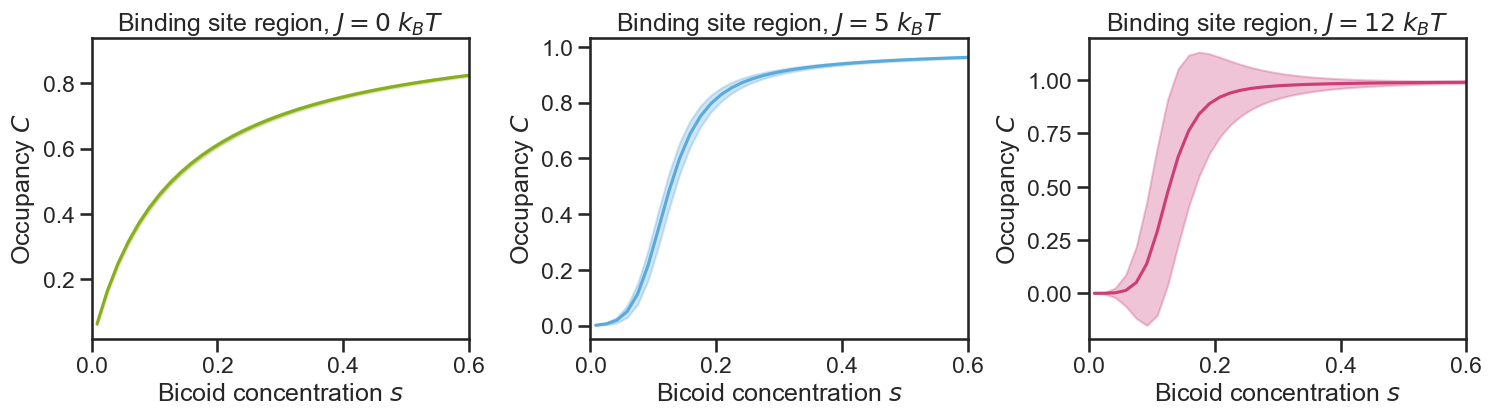

In [24]:
from GetExpression import get_expression_mean_and_var_steady_state
from bcd import read_bcd_data, discretize_concentrations

file_names = ['Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30',\
              'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30']

bcd_data = read_bcd_data('../../Parameters/Bcd_data/TG_normBcd')
number_of_samples = 60
rel_conc_bins, _, _ = discretize_concentrations(bcd_data, number_of_samples)

colors = ['#88AE1D', '#5CAADB', '#CD3E78']
dark_colors = ['#749a09', '#b92a63']
file_name = file_names[0]
ID = 'SSNN'
padding = 'Binding site region'


file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}')

grid_prms, _, varied_prms = read_metadata(file)
shift_compensation        = read_files_shift_compensation(file)
_, means, stds            = read_files_means_and_vars(file, varied_prms)

xs = rel_conc_bins[:-1]+1/(2*number_of_samples)

fig, ax = plt.subplots(1,3,figsize=(15,4))
plt.tight_layout(w_pad=2)

## Mean and standard deviation of expression (shift compensated)
#idxs = np.arange(0,len(varied_prms.J_list),2)
idxs = [0, 5, 12]

for i, (J, eb, expression, stdev, color) in enumerate(zip(varied_prms.J_list[idxs], varied_prms.eb_list[idxs], means[idxs], stds[idxs], colors)):
    ax[i].plot(xs, expression, color=color, label=f'$J={round(J)}$ $k_BT$') #label=f'$J={round(J)}\ k_BT$,\n$e_b\\approx{round(eb,1)}\ k_BT$')
    ax[i].fill_between(xs, expression-stdev, expression+stdev, color=color, alpha=0.3)#, label='Standard deviation ($T_{avg}=10$ min.)')
    ax[i].set_title(padding+f', $J={round(J)}$ $k_BT$')

    ax[i].set_xlabel('Bicoid concentration $s$')
    ax[i].set_ylabel('Occupancy $C$')
    ax[i].set_xlim([0,0.6])

plt.savefig(f'../Figures/ReviewResponse_ExpressionCrurveComparison_600s_{ID}.svg',bbox_inches="tight")

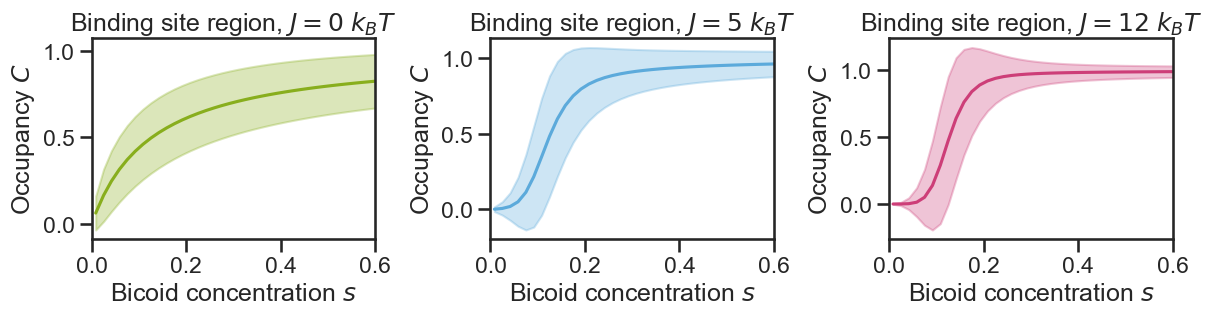

In [95]:
from GetExpression import get_expression_mean_and_var_steady_state
from bcd import read_bcd_data, discretize_concentrations

bcd_data = read_bcd_data('../../Parameters/Bcd_data/TG_normBcd')
number_of_samples = 60
rel_conc_bins, _, _ = discretize_concentrations(bcd_data, number_of_samples)

colors = ['#88AE1D', '#5CAADB', '#CD3E78']
dark_colors = ['#749a09', '#b92a63']
file_name = 'Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_10s_2025-09-11'
instantaneous = True
ID = 'SSNN'
padding = 'Binding site region'


file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}')

grid_prms, _, varied_prms = read_metadata(file)
shift_compensation        = read_files_shift_compensation(file)
_, means, stds            = read_files_means_and_vars(file, varied_prms, instantaneous)

xs = rel_conc_bins[:-1]+1/(2*number_of_samples)

fig, ax = plt.subplots(1,3,figsize=(12,3))
plt.tight_layout(w_pad=2)

## Mean and standard deviation of expression (shift compensated)
#idxs = np.arange(0,len(varied_prms.J_list),2)
idxs = [0, 5, 12]

for i, (J, eb, expression, stdev, color) in enumerate(zip(varied_prms.J_list[idxs], varied_prms.eb_list[idxs], means[idxs], stds[idxs], colors)):
    ax[i].plot(xs, expression, color=color, label=f'$J={round(J)}$ $k_BT$') #label=f'$J={round(J)}$ $k_BT$,\n$e_b\\approx{round(eb,1)}$ $k_BT$')
    ax[i].fill_between(xs, expression-stdev, expression+stdev, color=color, alpha=0.3)#, label='Standard deviation ($T_{avg}=10$ min.)')
    ax[i].set_title(padding+f', $J={round(J)}$ $k_BT$')

    ax[i].set_xlabel('Bicoid concentration $s$')
    ax[i].set_ylabel('Occupancy $C$')
    ax[i].set_xlim([0,0.6])

plt.savefig(f'../Figures/ReviewResponse_ExpressionCrurveComparison_0s_{ID}.svg',bbox_inches="tight")

## Binding site energies for different clustering strengths

[14.14331987 13.28957577 12.42115659 11.56136981 10.72057431  9.89013768
  9.06315401  8.2396233   7.41609259  6.5908354   5.76212525  4.92650919
  4.07362832  3.17240604  2.14342427]


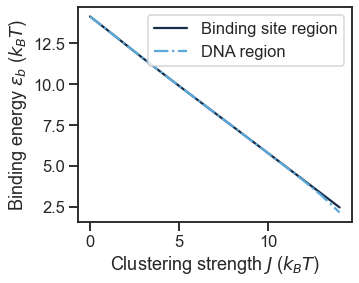

In [32]:
file_names = ['Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30',\
              'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30']

linestyles = ['-', '-.']
colors     = ['#172E48', '#5CAADB']
labels     = ['Binding site region', 'DNA region']

fig, ax = plt.subplots(figsize=(5,4))
plt.tight_layout(w_pad=4)

for i, (file_name, linestyle, color, label) in enumerate(zip(file_names, linestyles, colors, labels)):
    file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}') 
    grid_prms, sim_prms, varied_prms = read_metadata(file)
    ax.plot(varied_prms.J_list, varied_prms.eb_list, linestyle=linestyle, color=color, label=label)
    
ax.set_xlabel('Clustering strength $J$ ($k_BT$)')
ax.set_ylabel('Binding energy $\\epsilon_b$ ($k_BT$)')
ax.legend()

print(varied_prms.eb_list)

plt.savefig(f'../Figures/Manuscript_ShiftCompensationEb.svg',bbox_inches="tight")

## Effective Hill coefficient for different clustering strengths

7.204998794474997e-07
J: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
h: [1.00000172 1.3539696  1.70677739 2.07045139 2.48313468 2.94256419
 3.4059323  3.83853325 4.21585462 4.53780252 4.82078165 5.10415889
 5.48144898 6.17634619 7.44878975]


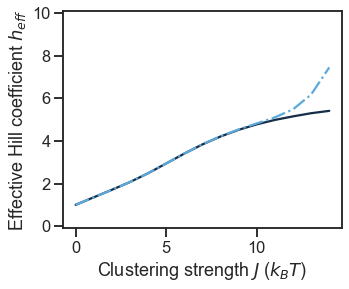

In [35]:
file_names = ['Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30',\
              'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30']

linestyles = ['-', '-.']
colors     = ['#172E48', '#5CAADB']
labels     = ['Binding site region', 'DNA region']

fig, ax = plt.subplots(figsize=(5,4))

for j, file_name in enumerate(file_names):
    file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}')

    grid_prms, _, varied_prms = read_metadata(file)
    shift_compensation        = read_files_shift_compensation(file)
    _, means, _               = read_files_means_and_vars(file, varied_prms)

    conc_range = prms.htf_to_c(grid_prms.beta, varied_prms.htf_list)
    c_05       = prms.htf_to_c(grid_prms.beta, shift_compensation.htf_05)
    Hill_eqn   = lambda c, n : prms.Hill_eqn(c, c_05, n)

    n_opt = np.zeros(len(means))
    for i, mean in enumerate(means):
        n_opt[i], _ = sp.optimize.curve_fit(Hill_eqn, conc_range, mean, bounds = ([0,100]))
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

    ax.plot(varied_prms.J_list, n_opt, linestyle=linestyles[j], color=colors[j], label=labels[j])

ax.set_xlabel('Clustering strength $J$ ($k_BT$)')
ax.set_ylabel('Effective Hill coefficient $h_{eff}$')
#ax.legend(['Binding site region', 'DNA region'])
ax.set_ylim([-0.1, 10.1])

print(c_05)
print('J:', varied_prms.J_list)
print('h:', n_opt)

plt.savefig(f'../Figures/Manuscript_HillCoefficient.svg', bbox_inches="tight")

# Correlation time

In [3]:
from Metadata import read_metadata
from Parameters import RunParameters
from GetExpression import get_expression_mean_and_var_steady_state

file_name = 'Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30'
file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}')
grid_prms, _, varied_prms = read_metadata(file)

def plot_correlationTimeAgainstClusteringStrength(htf_list, eb_list, J_list): 
    plt.figure(figsize=(6,4))
    
    ## Semilogarithmic plot
    for htf in htf_list:
        tau = np.zeros(len(J_list))
        sigma_squared = np.zeros(len(J_list))
        for j in range(len(J_list)):
            run_prms = RunParameters(htf, eb_list[j], J_list[j], None, grid_prms)
            _, sigma_squared[j], _, tau[j] = get_expression_mean_and_var_steady_state(run_prms, grid_prms, T=1/grid_prms.time_conversion, N=None, limit=True, return_all=True, diagonalize=False)

        tau = tau*grid_prms.time_conversion
        plt.semilogy(J_list, tau)
    
    plt.xlabel('Clustering strength $J$ ($k_BT$)')
    plt.ylabel('Correlation time $\\tau_c$ (s)')
    plt.legend(['$\\mu='+f'{htf}$' for htf in htf_list])

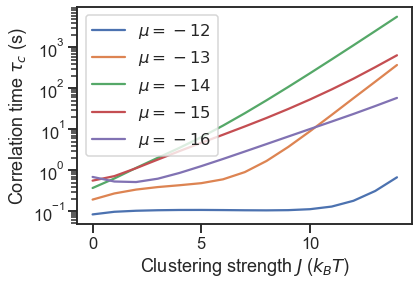

In [4]:
htf_list = [-12, -13, -14, -15, -16]
J_list = varied_prms.J_list
eb_list = varied_prms.eb_list

plot_correlationTimeAgainstClusteringStrength(htf_list, eb_list, J_list)

plt.savefig(f'../Figures/Manuscript_CorrelationTimeAgainstClusteringStrength.svg', bbox_inches="tight")

**With constant $e_b = 0$**:

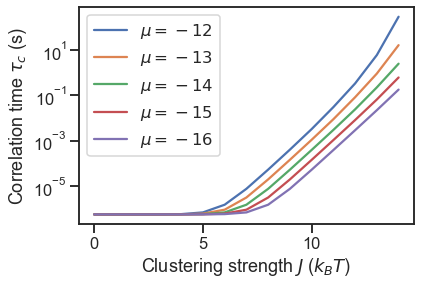

In [12]:
htf_list = [-12, -13, -14, -15, -16]
J_list = varied_prms.J_list
eb_list = [0]*len(J_list)

plot_correlationTimeAgainstClusteringStrength(htf_list, eb_list, J_list)

plt.savefig(f'../Figures/Manuscript_CorrelationTimeAgainstClusteringStrength_eb=0.svg', bbox_inches="tight")

# Signal to noise ratio

h_tf=-13.825259520676775
h_tf=-13.825259520676775


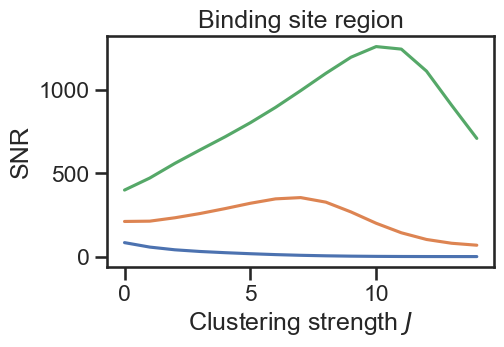

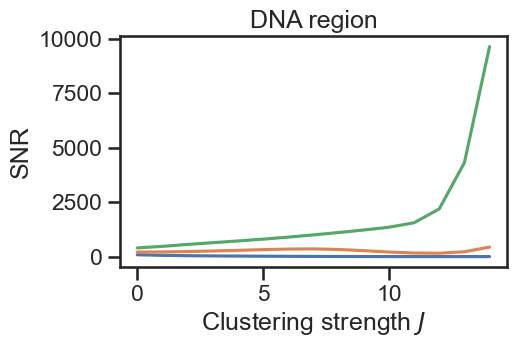

In [25]:
from GetExpression import get_expression_mean_and_var_steady_state
from bcd import read_bcd_data, discretize_concentrations

h = 10

file_names = ['Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30',\
              'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30']

bcd_data = read_bcd_data('../../Parameters/Bcd_data/TG_normBcd')
number_of_samples = 60
rel_conc_bins, _, _ = discretize_concentrations(bcd_data, number_of_samples)

for file_name, ID, padding in zip(file_names, ['SSNN', 'SS2N'], ['Binding site region', 'DNA region']):
    file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}')

    grid_prms, _, varied_prms = read_metadata(file)
    _, means, stds            = read_files_means_and_vars(file, varied_prms)

    print(f"h_tf={varied_prms.htf_list[h]}")
    
    plt.figure(figsize=(5,3))
    ax = plt.gca()
    ax.plot(varied_prms.J_list, (means/stds)[:,[10,30,60]])

    ## Plotting
    ax.set_xlabel('Clustering strength $J$')
    ax.set_ylabel('SNR')
    ax.set_title(padding)
    
    plt.savefig(f'../Figures/Manuscript_ExpressionCrurvesWithHillEquationFits_600s_{ID}.svg',bbox_inches="tight")

# Standard deviation

In [68]:
from Metadata import read_metadata
from FileReader import read_data
from FullMatrix import FullStates

def load_timeSweepData(datafile_idxs):
    T_list            = []
    data_list         = []
    steady_state_list = []
    means_list        = []
    stds_list         = []
    means_limit_list  = []
    stds_limit_list   = []

    for i in range(161):
        file_name = 'TimeSweep/TimeSweep_6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-05-19_'+f'{i}'
        file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}')

        grid_prms, sim_prms, varied_prms = read_metadata(file)

        T_list.append(sim_prms.T*grid_prms.time_conversion)

        if i in datafile_idxs:
            data = []
            for j, (J, eb) in enumerate(zip(varied_prms.J_list, varied_prms.eb_list)):
                data.append([])
                for h, htf in enumerate(varied_prms.htf_list):
                    dataset = read_data(file+f'_J{J}eb{eb}htf{htf}', sim_prms.runs)
                    data[-1].append(np.array(dataset[0]['mean binding site occupancy'], dtype='float'))
            data_list.append(data)

        f = open(file+'_steady_states', 'rb')
        steady_states = pickle.load(f)
        f.close()

        probabilities = []
        S = FullStates(grid_prms.L)
        sites = grid_prms.sites.flatten()
        for J, eb in zip(varied_prms.J_list, varied_prms.eb_list):
            probabilities.append([])
            for htf in varied_prms.htf_list:
                probabilities[-1].append(S.compact_states(steady_states[f'J{J}eb{eb}htf{htf}'][1], sites))
        steady_state_list.append(np.array(probabilities))

        f = open(file+'_means_and_vars', 'rb')
        means_and_vars = pickle.load(f)
        f.close()

        means = []
        stds  = []
        for J, eb in zip(varied_prms.J_list, varied_prms.eb_list):
            means.append([])
            stds.append([])
            for htf in varied_prms.htf_list:
                mu, sigma_squared = means_and_vars[f'J{J}eb{eb}htf{htf}']
                means[-1].append(mu)
                stds[-1].append(np.sqrt(sigma_squared))
        means = np.array(means)
        stds  = np.array(stds)

        means_list.append(means)
        stds_list.append(stds)

        f = open(file+'_means_and_vars_limit', 'rb')
        means_and_vars = pickle.load(f)
        f.close()

        means_limit = []
        stds_limit  = []
        for J, eb in zip(varied_prms.J_list, varied_prms.eb_list):
            means_limit.append([])
            stds_limit.append([])
            for htf in varied_prms.htf_list:
                mu, sigma_squared = means_and_vars[f'J{J}eb{eb}htf{htf}']
                means_limit[-1].append(mu)
                stds_limit[-1].append(np.sqrt(sigma_squared))
        means_limit = np.array(means_limit)
        stds_limit  = np.array(stds_limit)

        means_limit_list.append(means_limit)
        stds_limit_list.append(stds_limit)

    idxs              = np.argsort(T_list)
    T_list            = np.array(T_list)[idxs]
    T_idxs            = np.where(np.any([idxs == i for i in datafile_idxs], axis=0))[0]
    data_idxs         = np.concatenate([np.where(datafile_idxs == i)[0] for i in idxs[T_idxs]])
    data_list         = np.array(data_list)[data_idxs]
    steady_state_list = np.array(steady_state_list)[idxs]
    means_list        = np.array(means_list)[idxs]
    stds_list         = np.array(stds_list)[idxs]
    means_limit_list  = np.array(means_limit_list)[idxs]
    stds_limit_list   = np.array(stds_limit_list)[idxs]
    
    print(datafile_idxs)
    print(idxs)
    print(T_idxs)
    print(idxs[T_idxs])
    print(data_idxs)

    return grid_prms, sim_prms, varied_prms, T_list, T_idxs, data_idxs, data_list, steady_state_list, means_list, stds_list, means_limit_list, stds_limit_list

In [69]:
# Time sweep files 0-100 contain results for log spaced averaging times between 0.01 and 1000 min.
# Time sweep files 101-160 contain results for log spaced averaging times between 0.00001 and 0.01 min.
# Note that from 70 to 100, results are only available for every 10th index (70, 80, 90, 100), since calculations took too long.

datafile_idxs = np.concatenate((np.arange(71), np.arange(101,161)))                   # For standard deviation plots

grid_prms, sim_prms, varied_prms, T_list, T_idxs, data_idxs, data_list, steady_state_list, means_list, stds_list, means_limit_list, stds_limit_list = load_timeSweepData(datafile_idxs)

C:\Users\tamaramijatovi\AppData\Local\Temp\ipykernel_15736\1359028095.py:56: RuntimeWarning: invalid value encountered in sqrt
  stds[-1].append(np.sqrt(sigma_squared))


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160]
[101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160   0   1   2   3   4   5   6   7   8   9  10  11
  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54 

In [42]:
from Parameters import RunParameters
from GetExpression import get_expression_mean_and_var_steady_state

lightblue = '#5CAADB'
darkblue  = '#172E48'
lightorange = '#FBB44D'
darkorange  = '#9A4508'

def loglogPlot_standardDevtionAgainsAveragingTime(j, h):
    data_reshaped = np.reshape(data_list[:, j, h], (len(T_list[T_idxs]),5,20))
    std = np.std(data_reshaped, axis=-1)
    data_std = np.mean(std, axis=-1)
    data_std2 = np.std(std, axis=-1)

    ## Logarithic plot
    plt.figure(figsize=(5.5,4))
    
    plt.loglog(T_list[T_idxs], data_std, color=lightblue, label='Simulation results')
    plt.fill_between(T_list[T_idxs], data_std+data_std2, data_std-data_std2, color=lightblue, alpha=0.3)
    plt.loglog(T_list[T_idxs], stds_list[T_idxs,j,h], color=lightorange, label='Analytical prediction')
    plt.xlabel('Averaging time $\\tau$ (s)')
    plt.ylabel('Standard deviation $\sigma_{C}$')
    #plt.xlim(left=10**-2)
    plt.ylim(top=1)
    
    run_prms = RunParameters(varied_prms.htf_list[h], varied_prms.eb_list[j], varied_prms.J_list[j], None, grid_prms)
    _, sigma_squared, _, tau = get_expression_mean_and_var_steady_state(run_prms, grid_prms, T=1/grid_prms.time_conversion, N=None, limit=True, return_all=True, diagonalize=False)
    plt.plot(T_list[T_idxs], [np.sqrt(sigma_squared)]*len(T_idxs), '--', color=darkblue, label='$\sigma_{C}=\sigma_{inst}$')
    plt.loglog(T_list[T_idxs], stds_limit_list[T_idxs,j,h], '--', color=darkorange, label='$\sigma_{C}=\\sqrt{(2\\tau_c)/\\tau}\sigma_{inst}$')#label='Analytical prediction ($T\gg\\tau_n$)')
    plt.loglog([2*tau*grid_prms.time_conversion]*2, [min(data_std-data_std2),1], ':', color='gray', label='$\\tau=2\\tau_c$')
    
#     h, l = plt.gca().get_legend_handles_labels()
#     legend1 = plt.legend(h[2:], l[2:], ncol=3, bbox_to_anchor=(-0.3, 1.3), loc='upper left')
#     plt.legend(h[:2], l[:2])
#     plt.gca().add_artist(legend1)
    
    h, l = plt.gca().get_legend_handles_labels()
    legend2 = plt.legend([h[2], h[3]], [l[2], l[3]], ncol=2, bbox_to_anchor=(-0.18, 1.3), loc='upper left')
    plt.legend([h[0], h[1], h[4]], [l[0], l[1], l[4]])
    plt.gca().add_artist(legend2)


$h_{tf}$ = -14.0, $J$ = 3.5,  $e_b$ = 11.140108819624526


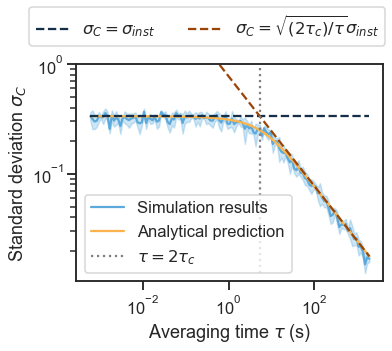

In [43]:
h = 4
j = 1

print('$h_{tf}$ = '+f'{varied_prms.htf_list[h]}, $J$ = {varied_prms.J_list[j]},  $e_b$ = {varied_prms.eb_list[j]}')

loglogPlot_standardDevtionAgainsAveragingTime(j, h)

plt.savefig(f'../Figures/Manuscript_StandardDeviationComparisonOverTime_log.svg', bbox_inches="tight")

## Standard deviation for different J

### Against averaging time

In [28]:
from Parameters import RunParameters
from GetExpression import get_expression_mean_and_var_steady_state

def plot_standardDeviationAgainstAveragingTime():
    
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    fig.tight_layout(h_pad=4,w_pad=4)
    
    ## Semilogarithmic plot
    for i, h in enumerate([4,6]):
        ax[i].loglog(T_list[T_idxs], stds_list[T_idxs,:-1,h])
        ax[i].set_xlabel('Averaging time $\\tau$ (s)')
        ax[i].set_ylabel('Standard deviation $\sigma_{C}$')
        ax[i].set_title('$\\mu='+f'{varied_prms.htf_list[h]}$')

        # Instantaneous standard deviation and correlation time (analytical)
        ax[i].set_prop_cycle(None)
        tau = np.zeros(len(varied_prms.J_list[:-1]))
        sigma_squared = np.zeros(len(varied_prms.J_list[:-1]))
        for j in range(len(varied_prms.J_list[:-1])):
            run_prms = RunParameters(varied_prms.htf_list[h], varied_prms.eb_list[j], varied_prms.J_list[j], None, grid_prms)
            _, sigma_squared[j], _, tau[j] = get_expression_mean_and_var_steady_state(run_prms, grid_prms, T=1/grid_prms.time_conversion, N=None, limit=True, return_all=True, diagonalize=False)
            ax[i].loglog([2*tau[j]*grid_prms.time_conversion]*2, [0.001,1], ':', color=f'C{j}', label='$2\tau$')

            ## Equation 9 and 10 from Skoge et al.
            func = lambda x : 2*(x+np.exp(-x)-1)/(x**2)
            tau_avg = np.logspace(-3,3,1000)
            ax[i].loglog(tau_avg, np.sqrt(sigma_squared[j]*func(tau_avg/(tau[j]*grid_prms.time_conversion))), 'k:')
            
    ax[0].legend([f'$J={round(J,1)}$' for J in varied_prms.J_list[:-1]])


<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tamaramijatovi\AppData\Local\Temp\ipykernel_15736\694411351.py:13: SyntaxWarning: invalid escape sequence '\s'
  ax[i].set_ylabel('Standard deviation $\sigma_{C}$')


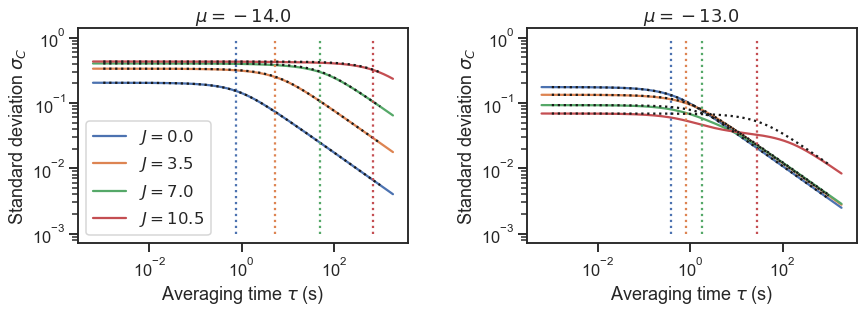

In [54]:
plot_standardDeviationAgainstAveragingTime()
plt.savefig(f'../Figures/Manuscript_StandardDeviationAgainstAveragingTime.svg', bbox_inches="tight")

### Against occupancy

In [61]:
import numpy as np

def bisection(f, a, b, tol): 
    # approximates a root, R, of f bounded 
    # by a and b to within tolerance 
    # | f(m) | < tol with m the midpoint 
    # between a and b Recursive implementation
    
    # check if a and b bound a root
    if np.sign(f(a)) == np.sign(f(b)):
        raise Exception(
         "The scalars a and b do not bound a root")
        
    # get midpoint
    m = (a + b)/2
    
    if np.abs(f(m)) < tol:
        # stopping condition, report m as root
        return m
    elif np.sign(f(a)) == np.sign(f(m)):
        # case where m is an improvement on a. 
        # Make recursive call with a = m
        return bisection(f, m, b, tol)
    elif np.sign(f(b)) == np.sign(f(m)):
        # case where m is an improvement on b. 
        # Make recursive call with b = m
        return bisection(f, a, m, tol)
    
#Taken from: https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter19.03-Bisection-Method.html

In [ ]:
from GetExpression import get_expression_steady_state, get_expression_mean_and_var_steady_state

def calculate_standard_deviation_per_occupancy(grid_prms, J_list, eb_list, T_list=[600]):
    expression = np.linspace(0.1, 0.9, 9)

    # Step 1: Use bisection method to find for each J the h_tf such that mean has a particular value (within the range 0.1, 0.9).
    htf_list = []
    for j in range(len(J_list)):
        htf_list.append([])
        for expr_val in expression:
            # Bisection
            def f(htf):
                run_prms = RunParameters(htf, eb_list[j], J_list[j], None, grid_prms)
                C = get_expression_steady_state(run_prms, grid_prms, N=None)
                #print(C, expr_val)
                return C-expr_val
            
            htf = bisection(f, -(J_list[j]+eb_list[j])-4, -(J_list[j]+eb_list[j])+4, 0.01)
            htf_list[-1].append(htf)

    # Step 2: For those combinations of J and h_tf, calculate the standard deviation for a range of averaging times.
    means_list = []
    stds_list  = []

    for T in T_list:
        means = []
        stds  = []
        for j in range(len(J_list)):    
            means.append([])
            stds.append([])
            for htf in htf_list[j]:
                run_prms = RunParameters(htf, eb_list[j], J_list[j], None, grid_prms)
                mu, sigma_squared = get_expression_mean_and_var_steady_state(run_prms, grid_prms, T/grid_prms.time_conversion, N=None, limit=False)
                means[-1].append(mu)
                stds[-1].append(np.sqrt(sigma_squared))
        means_list.append(means)
        stds_list.append(stds)

    means_list = np.array(means_list)
    stds_list  = np.array(stds_list)

    return means_list, stds_list

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tamaramijatovi\AppData\Local\Temp\ipykernel_15736\2146818003.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Standard deviation $\sigma_{C}$')


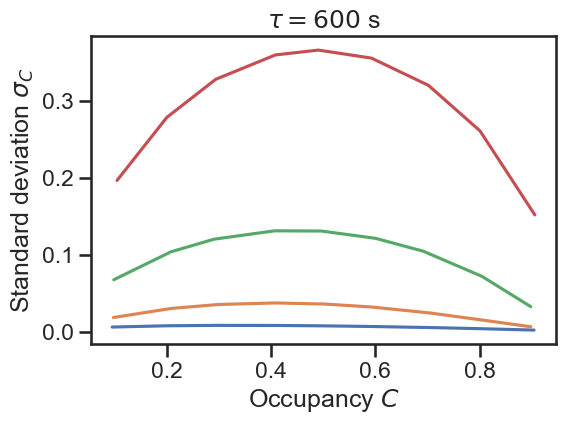

In [71]:
# Step 3: Plot standard deviations

T_list=[600]
means_list, stds_list = calculate_standard_deviation_per_occupancy(grid_prms, varied_prms.J_list[:-1], varied_prms.eb_list[:-1], T_list)

idx = -1

plt.figure(figsize=(6,4))
plt.plot(means_list[idx,:,:].T, stds_list[idx,:,:].T)
plt.xlabel('Occupancy $C$')
plt.ylabel('Standard deviation $\sigma_{C}$')
plt.title(f'$\\tau={T_list[idx]}$ s')
#plt.legend([f'$J={round(J,1)}$' for J in J_list])

plt.savefig(f'../Figures/Manuscript_StandardDeviationAgainstExpressionLevelForDifferentAveragingTimes.svg', bbox_inches="tight")

In [75]:
file_name = 'Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30'
file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}')

T_list=[600]
grid_prms, sim_prms, varied_prms = read_metadata(file)
means_list, stds_list = calculate_standard_deviation_per_occupancy(grid_prms, varied_prms.J_list[:-1], varied_prms.eb_list[:-1], T_list)


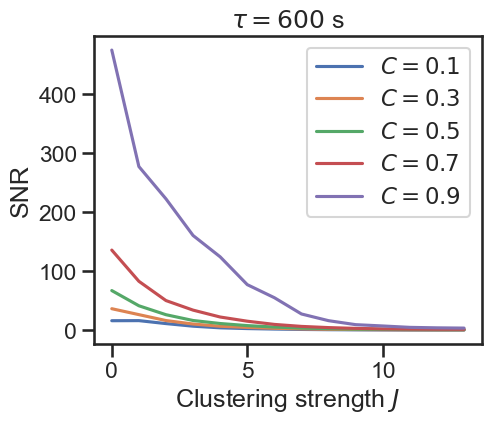

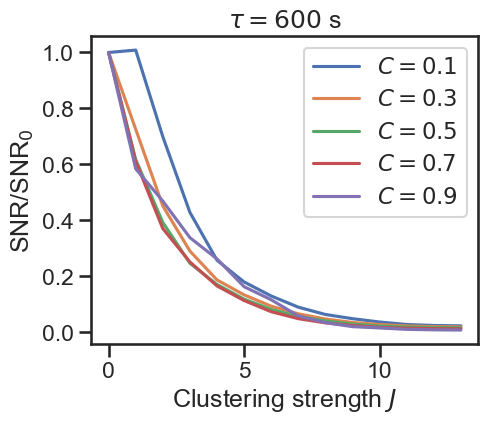

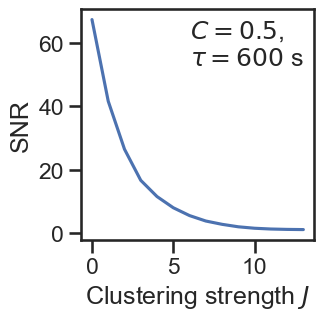

In [89]:
# Step 3: Plot signal to noise ratios

idx = -1
c = 4  # c = 4 gives an occupancy of 0.5

plt.figure(figsize=(5,4))
plt.plot(varied_prms.J_list[:-1], (means_list/stds_list)[idx,:,::2])
plt.xlabel('Clustering strength $J$')
plt.ylabel('SNR')
plt.title(f'$\\tau={T_list[idx]}$ s')
plt.legend([f'$C={round(C,1)}$' for C in expression[::2]])

plt.savefig(f'../Figures/Manuscript_SNRAgainstClusteringStrengthForDifferentAveragingTimes.svg', bbox_inches="tight")

plt.figure(figsize=(5,4))
plt.plot(varied_prms.J_list[:-1], (means_list/stds_list)[idx,:,::2]/(means_list/stds_list)[idx,0,::2])
plt.xlabel('Clustering strength $J$')
plt.ylabel('SNR/SNR$_0$')
plt.title(f'$\\tau={T_list[idx]}$ s')
plt.legend([f'$C={round(C,1)}$' for C in expression[::2]])

plt.savefig(f'../Figures/Manuscript_SNRAgainstClusteringStrengthForDifferentAveragingTimes_rescaled.svg', bbox_inches="tight")

plt.figure(figsize=(3,3))
plt.plot(varied_prms.J_list[:-1], (means_list/stds_list)[idx,:,c])
plt.xlabel('Clustering strength $J$')
plt.ylabel('SNR')
plt.text(6, 53, f'$C={round(expression[c],1)}$,\n$\\tau={T_list[idx]}$ s')

plt.savefig(f'../Figures/Manuscript_SNRAgainstClusteringStrengthForDifferentAveragingTimes_C={round(expression[c],1)}.svg', bbox_inches="tight")


# Mutual information

## Recalculating Mutual Information

We want to recalculate the mutual information using $P(S)=\int_X P(S|X)P(X)$.

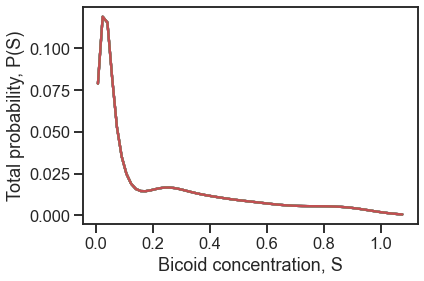

In [3]:
from MutualInformation import MutualInformation

file_name = 'Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30'
MI_SSNN = MutualInformation(file_name, analytical=True, stochastic=True, N_bins_gaussian=1000, N_bins_histogram=400)

file_name = 'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30'
MI_SS2N = MutualInformation(file_name, analytical=True, stochastic=True, N_bins_gaussian=1000, N_bins_histogram=400)

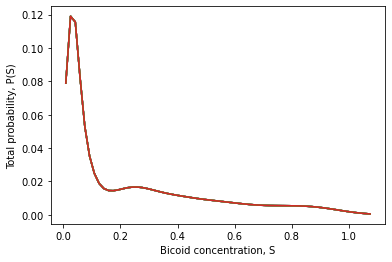

In [8]:
from MutualInformation import MutualInformation

file_name = 'Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_N6Expression_2024-04-30'
MI_SSNN = MutualInformation(file_name, analytical=True, stochastic=True, N_bins_gaussian=1000, N_bins_histogram=100)

file_name = 'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_N6Expression_2024-04-30'
MI_SS2N = MutualInformation(file_name, analytical=True, stochastic=True, N_bins_gaussian=1000, N_bins_histogram=100)

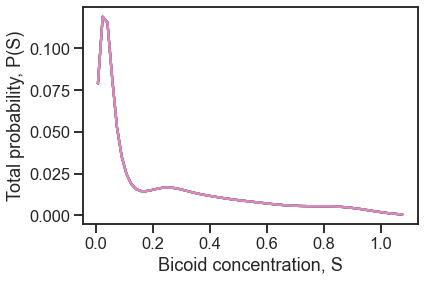

In [3]:
from MutualInformation import MutualInformation

file_name = 'Measurement/6Sites_2Padding_Periodic_SteadyState_InfiniteBath_Occupancy_2024-04-30'
MI_SS2Y = MutualInformation(file_name, analytical=True, stochastic=True, N_bins_gaussian=1000, N_bins_histogram=400)

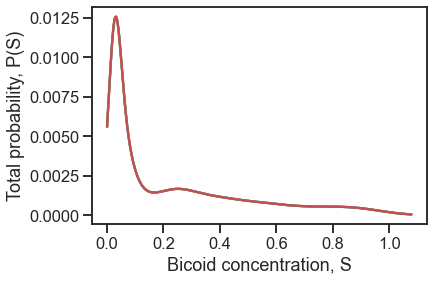

In [20]:
from MutualInformation import MutualInformation

file_name = '6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2025-05-09' # Increased concentration sampling
MI_IncreasedSampling_SSNN = MutualInformation(file_name, analytical=True, stochastic=False, N_bins_gaussian=1000, conc_samples=600)

file_name = '6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2025-05-09' # Increased concentration sampling
MI_IncreasedSampling_SS2N = MutualInformation(file_name, analytical=True, stochastic=False, N_bins_gaussian=1000, conc_samples=600)

## Plotting Mutual Information

In [6]:
from matplotlib.colors import LinearSegmentedColormap

new_oranges = LinearSegmentedColormap.from_list("flow_orange", ["#fdb74f", "#953f07"])
new_blues = LinearSegmentedColormap.from_list("flow_blue", ["#5fb0e1", "#040a1d"])

linestyles = ['-', '-.']
colors_blue   = ['#172E48', '#5CAADB']
colors_orange = ['#9A4508', '#FBB44D']
labels     = ['Binding site region:\n', 'DNA region:                 \n']

def plot_mutual_information(Varied_prms, I, ax=None, ls='-', c='C0', alpha=1, plot_max=True, I_min=0):
    if ax == None:
        fig, ax = plt.subplots()

    if plot_max:
        max_I_idx = np.argmax(I)
        ax.plot([Varied_prms.J_list[max_I_idx],Varied_prms.J_list[max_I_idx]], [I_min, I[max_I_idx]], color=c, linestyle='--', lw=2, zorder=0, label='_nolegend_')

    ax.plot(Varied_prms.J_list, I, ls, c=c, label='Mutual infromation', alpha=alpha, lw=3)
    
    ax.legend()
    #ax.set_title('Mutual information')
    ax.set_xlabel('Clustering strength $J$ ($k_BT$)')
    ax.set_ylabel('Entropy / Mutual information (bits)')
    
def plot_mutual_information_histogram(Varied_prms, Is, plot_std=True, ax=None, ls='-', c='C0', alpha=1, plot_max=True, I_min=0):
    I_mean = np.mean(Is, axis=0)
    
    if ax == None:
        fig, ax = plt.subplots()
        
    plot_mutual_information(Varied_prms, I_mean, ls=ls, c=c, ax=ax, alpha=alpha, plot_max=plot_max, I_min=I_min)
    
    if plot_std:
        I_std  = np.std(Is, axis=0)
        ax.fill_between(Varied_prms.J_list, I_mean-I_std, I_mean+I_std, color=c, alpha=0.3*alpha)


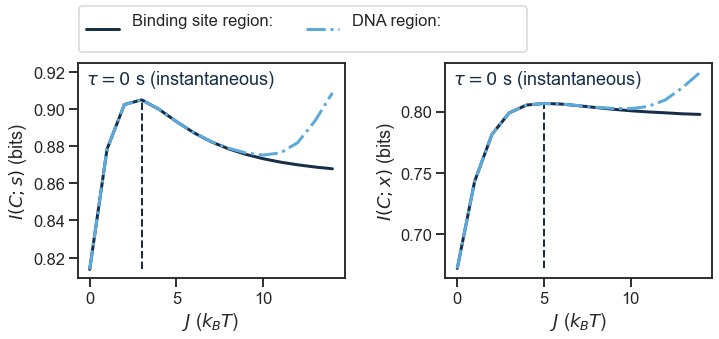

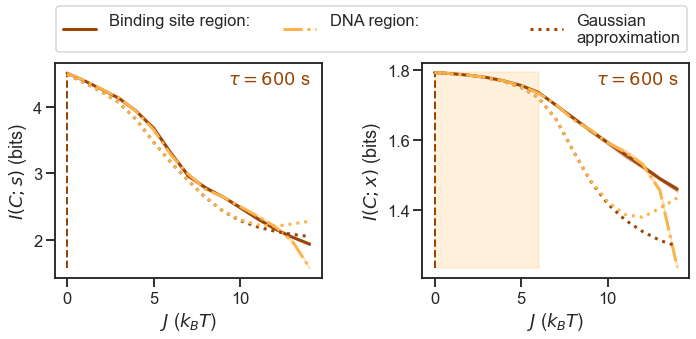

In [12]:
file_names = ['Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30',\
              'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30']

file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_names[0]}') 
f = open(file+f'_mutual_information_manuscript_1000_400', 'rb')
MI_SSNN = pickle.load(f)

file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_names[1]}') 
f = open(file+f'_mutual_information_manuscript_1000_400', 'rb')
MI_SS2N = pickle.load(f)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.tight_layout(w_pad=3)

I_min_S = np.min([np.min(MI_SSNN['steady state']['I_CS']), np.min(MI_SS2N['steady state']['I_CS'])])
I_min_X = np.min([np.min(MI_SSNN['steady state']['I_CX']), np.min(MI_SS2N['steady state']['I_CX'])])

for I_dict, ls, color, plot_max in zip([MI_SSNN, MI_SS2N], linestyles, colors_blue, [True, False]):
    plot_mutual_information(I_dict['variables'], I=I_dict['steady state']['I_CS'], ax=ax[0], ls=ls, c=color, I_min=I_min_S, plot_max=plot_max)
    plot_mutual_information(I_dict['variables'], I=I_dict['steady state']['I_CX'], ax=ax[1], ls=ls, c=color, I_min=I_min_X, plot_max=plot_max)

#ax[0].set_title('Single measurement')
ax[0].set_xlabel('$J$ ($k_BT$)')
ax[0].set_ylabel('$I(C;s)$ (bits)') #'Mutual information, $I(C, S)$ (bits)'
ax[0].legend(labels, ncol=3, bbox_to_anchor=(-0.0255, 1.3), loc='upper left') 
ax[0].set_ylim(top=0.925)
x_min, x_max = ax[0].get_xlim()
y_min, y_max = ax[0].get_ylim()
ax[0].text(x_min+0.03*(x_max-x_min), y_max-0.1*(y_max-y_min), '$\\tau=0$ s (instantaneous)', color=colors_blue[0])

#ax[1].set_title('Single measurement')
ax[1].set_xlabel('$J$ ($k_BT$)')
ax[1].set_ylabel('$I(C;x)$ (bits)') #'Mutual information, $I(C, X)$ (bits)'
ax[1].get_legend().remove()
x_min, x_max = ax[1].get_xlim()
y_min, y_max = ax[1].get_ylim()
ax[1].text(x_min+0.03*(x_max-x_min), y_max-0.1*(y_max-y_min), '$\\tau=0$ s (instantaneous)', color=colors_blue[0])
    
plt.savefig(f'../Figures/Manuscript_MutualInformationSingleMeasurement.svg', bbox_inches="tight")

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.tight_layout(w_pad=3)

I_min_S = np.min([np.min(MI_SSNN['histogram']['I_CS']), np.min(MI_SSNN['gaussian']['I_CS']), np.min(MI_SS2N['histogram']['I_CS']), np.min(MI_SS2N['gaussian']['I_CS'])])
I_min_X = np.min([np.min(MI_SSNN['histogram']['I_CX']), np.min(MI_SSNN['gaussian']['I_CX']), np.min(MI_SS2N['histogram']['I_CX']), np.min(MI_SS2N['gaussian']['I_CX'])])
I_max_X = np.max([np.max(MI_SSNN['histogram']['I_CX']), np.max(MI_SS2N['histogram']['I_CX'])])

for I_dict, ls, color, plot_max in zip([MI_SSNN, MI_SS2N], linestyles, colors_orange, [True, False]):
    plot_mutual_information_histogram(I_dict['variables'], Is=I_dict['histogram']['I_CS'], ax=ax[0], ls=ls, c=color, I_min=I_min_S, plot_max=plot_max)
    plot_mutual_information_histogram(I_dict['variables'], Is=I_dict['histogram']['I_CX'], ax=ax[1], ls=ls, c=color, I_min=I_min_X, plot_max=plot_max)

for I_dict, ls, color in zip([MI_SSNN, MI_SS2N], [':', ':'], colors_orange):
    plot_mutual_information(I_dict['variables'], I=I_dict['gaussian']['I_CS'], ax=ax[0], ls=ls, c=color, plot_max=False)
    plot_mutual_information(I_dict['variables'], I=I_dict['gaussian']['I_CX'], ax=ax[1], ls=ls, c=color, plot_max=False)
    
#ax[0].set_title('Repeated measurement')
ax[0].set_xlabel('$J$ ($k_BT$)')
ax[0].set_ylabel('$I(C;s)$ (bits)') #'Mutual information, $I(C, S)$ (bits)'
ax[0].legend(labels + ['Gaussian\napproximation'], ncol=3, bbox_to_anchor=(-0.0255, 1.3), loc='upper left')    
x_min, x_max = ax[0].get_xlim()
y_min, y_max = ax[0].get_ylim()
ax[0].text(x_max-0.35*(x_max-x_min), y_max-0.1*(y_max-y_min), '$\\tau=600$ s', color=colors_orange[0])
#ax[1].set_ylim(bottom=0)

#ax[1].set_title('Repeated measurement')
ax[1].set_xlabel('$J$ ($k_BT$)')
ax[1].set_ylabel('$I(C;x)$ (bits)') #'Mutual information, $I(C, X)$ (bits)'
ax[1].get_legend().remove()
x_min, x_max = ax[1].get_xlim()
y_min, y_max = ax[1].get_ylim()
ax[1].text(x_max-0.35*(x_max-x_min), y_max-0.1*(y_max-y_min), '$\\tau=600$ s', color=colors_orange[0])

# Exploration
# ax[1].plot([0,13], [0.95*I_max_X, 0.95*I_max_X], 'k:')
# ax[1].plot([0,13], [0.99*I_max_X, 0.99*I_max_X], 'k:')
# ax[1].fill_between([0,np.max(np.where(np.maximum(np.mean(MI_SSNN['histogram']['I_CX'], axis=0),np.mean(MI_SS2N['histogram']['I_CX'], axis=0))>0.95*I_max_X))], [I_min_X, I_min_X], [I_max_X, I_max_X], color='lightgray', alpha=0.5, zorder=0)
# ax[1].fill_between([0,np.max(np.where(np.maximum(np.mean(MI_SSNN['histogram']['I_CX'], axis=0),np.mean(MI_SS2N['histogram']['I_CX'], axis=0))>0.99*I_max_X))], [I_min_X, I_min_X], [I_max_X, I_max_X], color='lightgray', alpha=0.5, zorder=0)
ax[1].fill_between([0,6], [I_min_X, I_min_X], [I_max_X, I_max_X], color=colors_orange[1], alpha=0.2, zorder=0, label='_nolegend_')
#ax[1].set_ylim(bottom=0)

plt.savefig(f'../Figures/Manuscript_MutualInformationRepeatedMeasurement.svg', bbox_inches="tight")

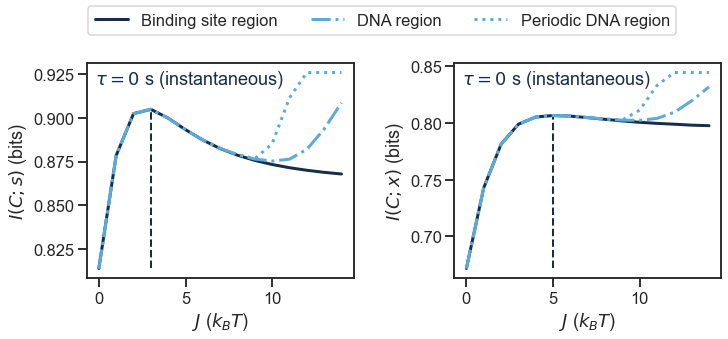

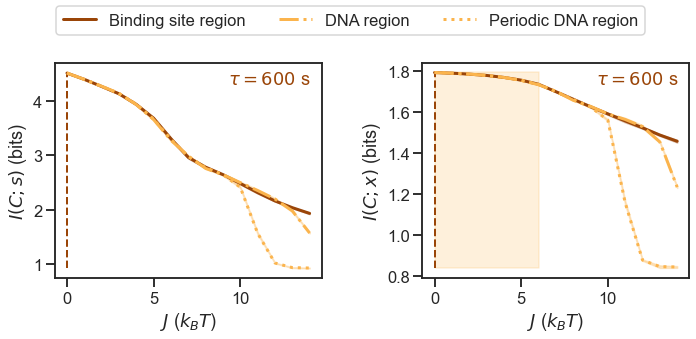

In [13]:
file_names = ['Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30',\
              'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30',\
              'Measurement/6Sites_2Padding_Periodic_SteadyState_InfiniteBath_Occupancy_2024-04-30']

file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_names[0]}') 
f = open(file+f'_mutual_information_manuscript_1000_400', 'rb')
MI_SSNN = pickle.load(f)

file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_names[1]}') 
f = open(file+f'_mutual_information_manuscript_1000_400', 'rb')
MI_SS2N = pickle.load(f)

file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_names[2]}') 
f = open(file+f'_mutual_information_manuscript_1000_400', 'rb')
MI_SS2Y = pickle.load(f)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.tight_layout(w_pad=3)

I_min_S = np.min([np.min(MI_SSNN['steady state']['I_CS']), np.min(MI_SS2N['steady state']['I_CS']), np.min(MI_SS2Y['steady state']['I_CS'])])
I_min_X = np.min([np.min(MI_SSNN['steady state']['I_CX']), np.min(MI_SS2N['steady state']['I_CX']), np.min(MI_SS2Y['steady state']['I_CX'])])

for I_dict, ls, color, plot_max in zip([MI_SSNN, MI_SS2N, MI_SS2Y], linestyles + [':'], colors_blue+[colors_blue[1]], [True, False, False]):
    plot_mutual_information(I_dict['variables'], I=I_dict['steady state']['I_CS'], ax=ax[0], ls=ls, c=color, I_min=I_min_S, plot_max=plot_max)
    plot_mutual_information(I_dict['variables'], I=I_dict['steady state']['I_CX'], ax=ax[1], ls=ls, c=color, I_min=I_min_X, plot_max=plot_max)

#ax[0].set_title('Single measurement')
ax[0].set_xlabel('$J$ ($k_BT$)')
ax[0].set_ylabel('$I(C;s)$ (bits)') #'Mutual information, $I(C, S)$ (bits)'
ax[0].legend(['Binding site region', 'DNA region', 'Periodic DNA region'], ncol=3, bbox_to_anchor=(-0.0255, 1.3), loc='upper left')    
x_min, x_max = ax[0].get_xlim()
y_min, y_max = ax[0].get_ylim()
ax[0].text(x_min+0.03*(x_max-x_min), y_max-0.1*(y_max-y_min), '$\\tau=0$ s (instantaneous)', color=colors_blue[0])

#ax[1].set_title('Single measurement')
ax[1].set_xlabel('$J$ ($k_BT$)')
ax[1].set_ylabel('$I(C;x)$ (bits)') #'Mutual information, $I(C, X)$ (bits)'
ax[1].get_legend().remove()
x_min, x_max = ax[1].get_xlim()
y_min, y_max = ax[1].get_ylim()
ax[1].text(x_min+0.03*(x_max-x_min), y_max-0.1*(y_max-y_min), '$\\tau=0$ s (instantaneous)', color=colors_blue[0])
    
plt.savefig(f'../Figures/Manuscript_MutualInformationSingleMeasurement_WithPeriodicGrid.svg', bbox_inches="tight")

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.tight_layout(w_pad=3)

I_min_S = np.min([np.min(MI_SSNN['histogram']['I_CS']), np.min(MI_SS2N['histogram']['I_CS']), np.min(MI_SS2Y['histogram']['I_CS'])])
I_min_X = np.min([np.min(MI_SSNN['histogram']['I_CX']), np.min(MI_SS2N['histogram']['I_CX']), np.min(MI_SS2Y['histogram']['I_CX'])])
I_max_X = np.max([np.max(MI_SSNN['histogram']['I_CX']), np.max(MI_SS2N['histogram']['I_CX']), np.max(MI_SS2Y['histogram']['I_CX'])])

for I_dict, ls, color, plot_max in zip([MI_SSNN, MI_SS2N, MI_SS2Y], linestyles+[':'], colors_orange+[colors_orange[1]], [True, False, False]):
    plot_mutual_information_histogram(I_dict['variables'], Is=I_dict['histogram']['I_CS'], ax=ax[0], ls=ls, c=color, I_min=I_min_S, plot_max=plot_max)
    plot_mutual_information_histogram(I_dict['variables'], Is=I_dict['histogram']['I_CX'], ax=ax[1], ls=ls, c=color, I_min=I_min_X, plot_max=plot_max)

#ax[0].set_title('Repeated measurement')
ax[0].set_xlabel('$J$ ($k_BT$)')
ax[0].set_ylabel('$I(C;s)$ (bits)') #'Mutual information, $I(C, S)$ (bits)'
ax[0].legend(['Binding site region', 'DNA region', 'Periodic DNA region'], ncol=3, bbox_to_anchor=(-0.0255, 1.3), loc='upper left')    
x_min, x_max = ax[0].get_xlim()
y_min, y_max = ax[0].get_ylim()
ax[0].text(x_max-0.35*(x_max-x_min), y_max-0.1*(y_max-y_min), '$\\tau=600$ s', color=colors_orange[0])
#ax[1].set_ylim(bottom=0)

#ax[1].set_title('Repeated measurement')
ax[1].set_xlabel('$J$ ($k_BT$)')
ax[1].set_ylabel('$I(C;x)$ (bits)') #'Mutual information, $I(C, X)$ (bits)'
ax[1].get_legend().remove()
x_min, x_max = ax[1].get_xlim()
y_min, y_max = ax[1].get_ylim()
ax[1].text(x_max-0.35*(x_max-x_min), y_max-0.1*(y_max-y_min), '$\\tau=600$ s', color=colors_orange[0])

# Exploration
# ax[1].plot([0,13], [0.95*I_max_X, 0.95*I_max_X], 'k:')
# ax[1].plot([0,13], [0.99*I_max_X, 0.99*I_max_X], 'k:')
# ax[1].fill_between([0,np.max(np.where(np.maximum(np.mean(MI_SSNN['histogram']['I_CX'], axis=0),np.mean(MI_SS2N['histogram']['I_CX'], axis=0))>0.95*I_max_X))], [I_min_X, I_min_X], [I_max_X, I_max_X], color='lightgray', alpha=0.5, zorder=0)
# ax[1].fill_between([0,np.max(np.where(np.maximum(np.mean(MI_SSNN['histogram']['I_CX'], axis=0),np.mean(MI_SS2N['histogram']['I_CX'], axis=0))>0.99*I_max_X))], [I_min_X, I_min_X], [I_max_X, I_max_X], color='lightgray', alpha=0.5, zorder=0)
ax[1].fill_between([0,6], [I_min_X, I_min_X], [I_max_X, I_max_X], color=colors_orange[1], alpha=0.2, zorder=0, label='_nolegend_')
#ax[1].set_ylim(bottom=0)

plt.savefig(f'../Figures/Manuscript_MutualInformationRepeatedMeasurement_WithPeriodicGrid.svg', bbox_inches="tight")

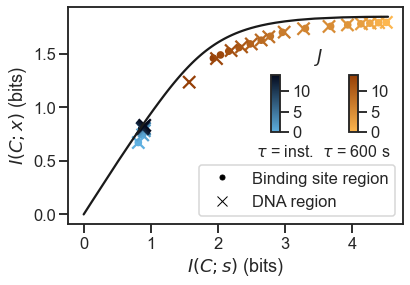

In [132]:
file_names = ['Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30',\
              'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2024-04-30']

fig = plt.figure(figsize=(6,4))

markers = ['.', 'x']
for file_name, marker in zip(file_names, markers):
    file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_name}') 
    f = open(file+f'_mutual_information_manuscript_1000_400', 'rb')
    MI = pickle.load(f)

    scatter1 = plt.scatter(MI['steady state']['I_CS'], MI['steady state']['I_CX'], c=I_dict['variables'].J_list, cmap=new_blues, marker=marker, s=150)
    scatter2 = plt.scatter(np.mean(MI['histogram']['I_CS'], axis=0), np.mean(MI['histogram']['I_CX'], axis=0), c=I_dict['variables'].J_list, cmap=new_oranges, marker=marker, facecolors='none', s=150)

m1 = mlines.Line2D([], [], color='black', marker=markers[0], linestyle='None',
                          markersize=10, label='Binding site region')
m2 = mlines.Line2D([], [], color='black', marker=markers[1], linestyle='None',
                          markersize=10, label='DNA region')
plt.legend([m1, m2], ['Binding site region', 'DNA region'])
    
limit_icg = np.load('../Parameters/Bcd_data/icg_bcd.npy')
limit_icx = np.load('../Parameters/Bcd_data/icx_bcd.npy')

plt.plot(limit_icg, limit_icx, 'k')

plt.xlabel('$I(C;s)$ (bits)')
plt.ylabel('$I(C;x)$ (bits)')

BboxPosn = plt.gca().get_position()
cbar_ticklabels = [0, 5, 10]
plt.gca().text(BboxPosn.x0 + 3.3, BboxPosn.y0 + 1.3, '$J$', fontsize=18)
cbar1 = fig.add_axes([BboxPosn.x0 + 0.47, BboxPosn.y0 + 0.32, 0.02, 0.2])
color_bar1 = plt.colorbar(scatter1, cax=cbar1, orientation='vertical', ticks=cbar_ticklabels)
plt.gca().text(BboxPosn.x0 - 25, BboxPosn.y0 - 6, r'$\tau$'+f' = inst.', fontsize=16)
cbar2 = fig.add_axes([BboxPosn.x0 + 0.65, BboxPosn.y0 + 0.32, 0.02, 0.2])
color_bar2 = plt.colorbar(scatter2, cax=cbar2, orientation='vertical', ticks=cbar_ticklabels)
plt.gca().text(BboxPosn.x0 - 45, BboxPosn.y0 - 6, r'$\tau$'+f' = {600:.0f} s', fontsize=16)

plt.savefig(f'../Figures/Manuscript_IBFigure.svg', bbox_inches="tight")

### Higher concentration sampling

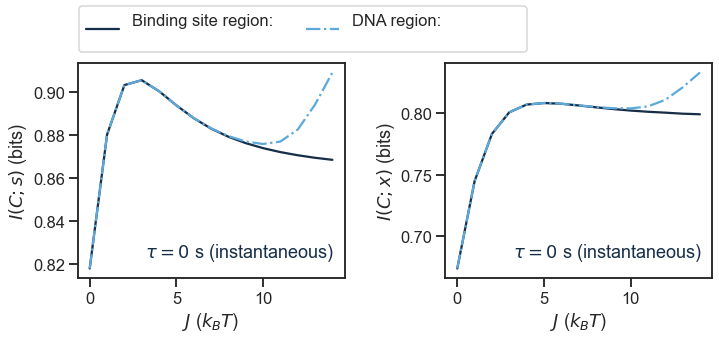

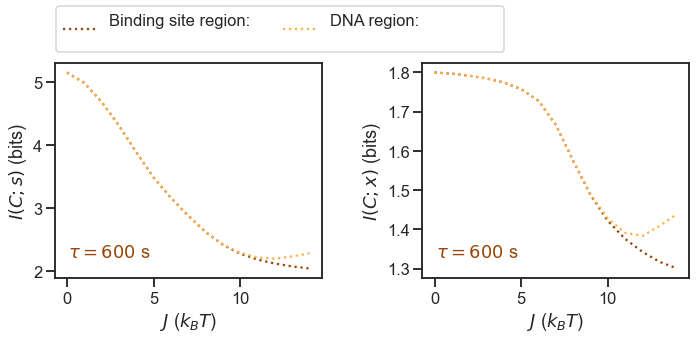

In [25]:
file_names = ['6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2025-05-09',\
              '6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_Occupancy_2025-05-09']

file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_names[0]}') 
f = open(file+f'_mutual_information_manuscript_1000_400', 'rb')
MI_SSNN = pickle.load(f)

file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_names[1]}') 
f = open(file+f'_mutual_information_manuscript_1000_400', 'rb')
MI_SS2N = pickle.load(f)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.tight_layout(w_pad=3)

for I_dict, ls, color in zip([MI_SSNN, MI_SS2N], linestyles, colors_blue):
    plot_mutual_information(I_dict['variables'], I=I_dict['steady state']['I_CS'], ax=ax[0], ls=ls, c=color)
    plot_mutual_information(I_dict['variables'], I=I_dict['steady state']['I_CX'], ax=ax[1], ls=ls, c=color)

#ax[0].set_title('Single measurement')
ax[0].set_xlabel('$J$ ($k_BT$)')
ax[0].set_ylabel('$I(C;s)$ (bits)') #'Mutual information, $I(C, S)$ (bits)'
ax[0].legend(labels, ncol=3, bbox_to_anchor=(-0.0255, 1.3), loc='upper left') 
x_min, x_max = ax[0].get_xlim()
y_min, y_max = ax[0].get_ylim()
ax[0].text(x_max-11.5, y_min+0.1*(y_max-y_min), '$\\tau=0$ s (instantaneous)', color=colors_blue[0])

#ax[1].set_title('Single measurement')
ax[1].set_xlabel('$J$ ($k_BT$)')
ax[1].set_ylabel('$I(C;x)$ (bits)') #'Mutual information, $I(C, X)$ (bits)'
ax[1].get_legend().remove()
x_min, x_max = ax[1].get_xlim()
y_min, y_max = ax[1].get_ylim()
ax[1].text(x_max-11.5, y_min+0.1*(y_max-y_min), '$\\tau=0$ s (instantaneous)', color=colors_blue[0])
    
plt.savefig(f'../Figures/Manuscript_MutualInformationSingleMeasurement_HigherConcentrationSampling.svg', bbox_inches="tight")

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.tight_layout(w_pad=3)

# for I_dict, ls, color in zip([MI_SSNN, MI_SS2N], linestyles, colors_orange):
#     plot_mutual_information_histogram(I_dict['variables'], Is=I_dict['histogram']['I_CS'], ax=ax[0], ls=ls, c=color)
#     plot_mutual_information_histogram(I_dict['variables'], Is=I_dict['histogram']['I_CX'], ax=ax[1], ls=ls, c=color)

for I_dict, ls, color in zip([MI_SSNN, MI_SS2N], [':', ':'], colors_orange):
    plot_mutual_information(I_dict['variables'], I=I_dict['gaussian']['I_CS'], ax=ax[0], ls=ls, c=color)
    plot_mutual_information(I_dict['variables'], I=I_dict['gaussian']['I_CX'], ax=ax[1], ls=ls, c=color)
    
#ax[0].set_title('Repeated measurement')
ax[0].set_xlabel('$J$ ($k_BT$)')
ax[0].set_ylabel('$I(C;s)$ (bits)') #'Mutual information, $I(C, S)$ (bits)'
ax[0].legend(labels + ['Gaussian\napproximation'], ncol=3, bbox_to_anchor=(-0.0255, 1.3), loc='upper left')    
x_min, x_max = ax[0].get_xlim()
y_min, y_max = ax[0].get_ylim()
ax[0].text(x_min+0.05*(x_max-x_min), y_min+0.1*(y_max-y_min), '$\\tau=600$ s', color=colors_orange[0])

#ax[1].set_title('Repeated measurement')
ax[1].set_xlabel('$J$ ($k_BT$)')
ax[1].set_ylabel('$I(C;x)$ (bits)') #'Mutual information, $I(C, X)$ (bits)'
ax[1].get_legend().remove()
x_min, x_max = ax[1].get_xlim()
y_min, y_max = ax[1].get_ylim()
ax[1].text(x_min+0.05*(x_max-x_min), y_min+0.1*(y_max-y_min), '$\\tau=600$ s', color=colors_orange[0])

plt.savefig(f'../Figures/Manuscript_MutualInformationRepeatedMeasurement_HigherConcentrationSampling.svg', bbox_inches="tight")

### All or nothing expresion

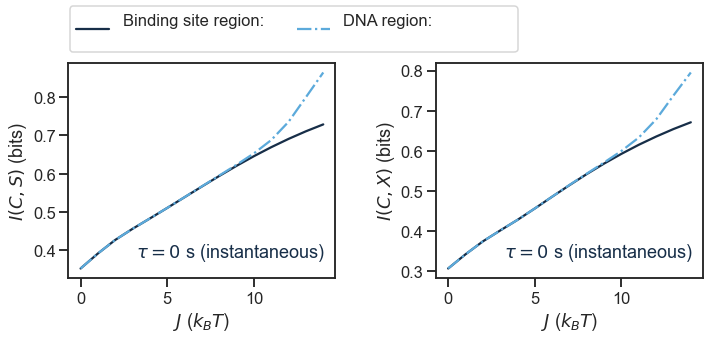

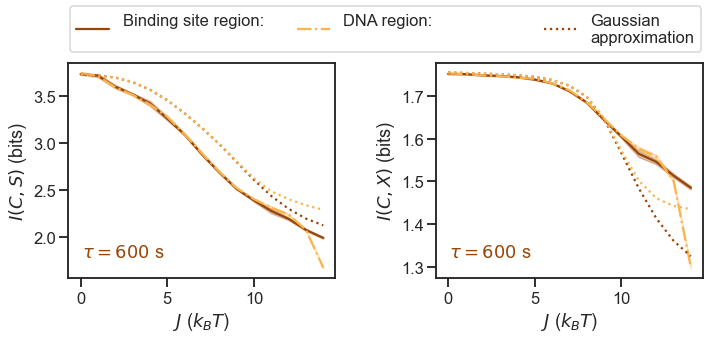

In [148]:
file_names = ['Measurement/6Sites_NoPadding_NonPeriodic_SteadyState_InfiniteBath_N6Expression_2024-04-30',\
              'Measurement/6Sites_2Padding_NonPeriodic_SteadyState_InfiniteBath_N6Expression_2024-04-30']

file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_names[0]}') 
f = open(file+f'_mutual_information_manuscript_1000_100', 'rb')
MI_SSNN = pickle.load(f)

file = os.path.join(os.path.realpath('__file__'), f'../../Data/{file_names[1]}') 
f = open(file+f'_mutual_information_manuscript_1000_100', 'rb')
MI_SS2N = pickle.load(f)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.tight_layout(w_pad=3)

for I_dict, ls, color in zip([MI_SSNN, MI_SS2N], linestyles, colors_blue):
    plot_mutual_information(I_dict['variables'], I=I_dict['steady state']['I_CS'], ax=ax[0], ls=ls, c=color)
    plot_mutual_information(I_dict['variables'], I=I_dict['steady state']['I_CX'], ax=ax[1], ls=ls, c=color)

#ax[0].set_title('Single measurement')
ax[0].set_xlabel('$J$ ($k_BT$)')
ax[0].set_ylabel('$I(C, S)$ (bits)') #'Mutual information, $I(C, S)$ (bits)'
ax[0].legend(labels, ncol=2, bbox_to_anchor=(-0.0255, 1.3), loc='upper left') 
x_min, x_max = ax[0].get_xlim()
y_min, y_max = ax[0].get_ylim()
ax[0].text(x_max-11.5, y_min+0.1*(y_max-y_min), '$\\tau=0$ s (instantaneous)', color=colors_blue[0])

#ax[1].set_title('Single measurement')
ax[1].set_xlabel('$J$ ($k_BT$)')
ax[1].set_ylabel('$I(C, X)$ (bits)') #'Mutual information, $I(C, X)$ (bits)'
ax[1].get_legend().remove()
x_min, x_max = ax[1].get_xlim()
y_min, y_max = ax[1].get_ylim()
ax[1].text(x_max-11.5, y_min+0.1*(y_max-y_min), '$\\tau=0$ s (instantaneous)', color=colors_blue[0])

plt.savefig(f'../Figures/Manuscript_MutualInformationSingleMeasurement_AllOccupiedExpression.svg', bbox_inches="tight")

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.tight_layout(w_pad=3)

for I_dict, ls, color in zip([MI_SSNN, MI_SS2N], linestyles, colors_orange):
    plot_mutual_information_histogram(I_dict['variables'], Is=I_dict['histogram']['I_CS'], ax=ax[0], ls=ls, c=color)
    plot_mutual_information_histogram(I_dict['variables'], Is=I_dict['histogram']['I_CX'], ax=ax[1], ls=ls, c=color)

for I_dict, ls, color in zip([MI_SSNN, MI_SS2N], [':', ':'], colors_orange):
    plot_mutual_information(I_dict['variables'], I=I_dict['gaussian']['I_CS'], ax=ax[0], ls=ls, c=color)
    plot_mutual_information(I_dict['variables'], I=I_dict['gaussian']['I_CX'], ax=ax[1], ls=ls, c=color)
    
#ax[0].set_title('Repeated measurement')
ax[0].set_xlabel('$J$ ($k_BT$)')
ax[0].set_ylabel('$I(C, S)$ (bits)') #'Mutual information, $I(C, S)$ (bits)'
ax[0].legend(labels + ['Gaussian\napproximation'], ncol=3, bbox_to_anchor=(-0.0255, 1.3), loc='upper left')
x_min, x_max = ax[0].get_xlim()
y_min, y_max = ax[0].get_ylim()
ax[0].text(x_min+0.05*(x_max-x_min), y_min+0.1*(y_max-y_min), '$\\tau=600$ s', color=colors_orange[0])

#ax[1].set_title('Repeated measurement')
ax[1].set_xlabel('$J$ ($k_BT$)')
ax[1].set_ylabel('$I(C, X)$ (bits)') #'Mutual information, $I(C, X)$ (bits)'
ax[1].get_legend().remove()
x_min, x_max = ax[1].get_xlim()
y_min, y_max = ax[1].get_ylim()
ax[1].text(x_min+0.05*(x_max-x_min), y_min+0.1*(y_max-y_min), '$\\tau=600$ s', color=colors_orange[0])

plt.savefig(f'../Figures/Manuscript_MutualInformationRepeatedMeasurement_AllOccupiedExpression.svg', bbox_inches="tight")